# **Project: Multitask Learning for Geometric Shape Classification and Counting**

## 1. Overview

In this project, you will design, implement, and evaluate a **multitask neural network** that performs **two tasks simultaneously**:

1. **Classification** – identify which pair of geometric shape types appears in a 28×28 binary image (135 possible configurations).
2. **Regression** – predict how many shapes of each type are present (6 regression targets).

This project focuses on **multi-task learning**, i.e., using one shared model to learn several related tasks at once. You will compare how adding an auxiliary task affects performance and training dynamics.

---

---

## 8. Experiments and analysis

You must train and compare **three model settings**:

| Setting | Description                                      |
| :------ | :----------------------------------------------- |
| 1       | **Classification-only:** λ_cnt = 0               |
| 2       | **Regression-only:** classification loss ignored |
| 3       | **Multitask:** λ_cnt = with your choose          |

For each experiment:

* Train until early stopping
* Record loss, accuracy, RMSE, and runtime
* Compare results and explain how λ influences learning
* Discuss whether multitask learning improves the main tasks

---

## 9. Final deliverables

You must submit .zip project with:

1. **Code** (`.ipynb` or `.py`) that:

   * Downloads and extracts the dataset
   * Defines dataset, dataloaders, model, loss, training loop, evaluation, and plotting
   * Can run start-to-end without interaction, and finishes within 30 minutes on Colab T4 GPUs
   * Includes three experiment configurations

2. **Report (2–4 pages, PDF)** including:
   * Section on (EDA) Exploratory Data Analysis in your report: no more than 3 graphs or tables describing the data set.
   * Model architecture
   * Description and justification of augmentations
   * Results table (loss, accuracy, RMSE for all runs)
   * Learning curves
   * Discussion on multitask effects

3. **README.md**:

   * Link to Colab version of task for fast replication.
   * Approximate runtime and resource requirements

---

## 10. Grading rubric

Component	Description	Points
1. Implementation correctness	Correct use of the fixed backbone, two-headed model, and proper training loop (classification + regression).	30%
2. Data & augmentations	Proper dataset loading, preprocessing, and at least three augmentations with brief justification.	20%
3. Evaluation & experiments	Correct computation of metrics (accuracy, F1, RMSE) and completion of all three λ configurations (λ=0, regression-only, your choice λ).	30%
4. Report & analysis
A clear separation of concerns (e.g. headers in notebooks, modules in code) and concise 2–4 page report with results tables, learning curves, confusion matrix, and short discussion on multitask effects and error examples.
20%

###### Readability and modularity will be considered within each grading component. Clear structure (headers in notebooks, docstrings, modular code) significantly improves evaluation speed. Emphasize using clear headers to help reviewers navigate efficiently.
---

Setup
===

In [1]:
# only needs to be run once
# UNCOMMENT THIS IF RUNNING FOR THE FIRST TIME.
!wget  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip

--2025-11-25 14:23:40--  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip [following]
--2025-11-25 14:23:41--  https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘data_gsn.zip’

data_gsn.zip        100%[===================>]   5.29M  --.-KB/s    in 0.04s   

2025-11-25 14:23:41 (124 MB/s) - ‘data_gsn.zip’ saved [5544261/5544261]



In [2]:
!pip3 install pillow torch torchvision

In [3]:
#Run this if you get `valueerror: module functions cannot set METH_CLASS or METH_STATIC`
!pip3 install -U numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 131.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.5 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "

In [5]:
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import tqdm
import PIL as pillow
from torchvision.transforms.functional import pil_to_tensor
import os
import enum

* Optimizer: **Adam**, learning rate = 1e-3
* Epochs: up to **100** (use **early stopping**)
* Batch sizes: **64** (train), **1000** (validation)
* Device: GPU allowed for Notebook, but your **final code must run on GPU within ~30 minutes**
* Random seed: set `torch.manual_seed(1)` for reproducibility
* Split: **exactly 9,000 train / 1,000 validation**

In [7]:
torch.manual_seed(1)
EPOCHS = 100
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_VALIDATION = 1000
TRAIN_SIZE = 9000

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Read and augment the dataset
===

* Reads `labels.csv`
* Loads the corresponding image (from `data/`)
* Returns both:
  * the image (as a tensor)
  * the labels (counts for 6 shapes)

For transformations, a separate class was introduced.

Load the dataset
----

In [9]:
class ImageSize:
  """
  Helper class to contain image size coordinates, for readability.
  """
  def __init__(self, x, y):
    self.x = x
    self.y = y

class Dataset(torch.utils.data.Dataset):

  """
  Dataset class. Handles reading, processing, and augmentation of the input data.
  """
  def __init__(self, path: str, transform=None, verbose: bool = True):
    """
    Initialize the dataset.
    :param path: path to the image folder.
    :param transform: transformations / augmentations to apply to the images.
    :param verbose: enable logging.
    """
    self.path = path
    self.verbose = verbose

    self.y = None
    self.image_data = None
    self.n_images = 0
    self.image_size = None

    self.transform = transform

    self.train = True
    if self.verbose:
      print("Initialized in verbose mode")

  def load(self) -> tuple[list, list]:
    """
    Load data.
    """
    if self.verbose:
      print("Reading all data")

    # Read labels
    if self.verbose:
      print("Reading labels")
    labels = pd.read_csv(os.path.join(self.path,"labels.csv"))
    self.n_images = len(labels)
    if self.verbose:
      print("Labels:")
      print(labels.head())
    names = labels["name"]
    self.y = torch.Tensor(labels[["squares", "circles", "up", "right", "down", "left"]].to_numpy())

    # Read data
    image_size = self.set_image_shape_by_example(names[0])
    self.image_data = torch.zeros((self.n_images, image_size.x * image_size.y)) # initialization

    for i in tqdm.tqdm(range(self.n_images)):
      with open(os.path.join(self.path, names[i]), "rb") as image_file:
        image = pillow.Image.open(image_file).convert('L')
        assert image.width == image_size.x and image.height == image_size.y, "Mismatched image size"

        self.image_data[i] = torchvision.transforms.functional \
                              .pil_to_tensor(image) \
                              .reshape((image_size.x * image_size.y,)) / 255.0

    if self.verbose:
      print(f"Data shape is {self.image_data.shape} ({self.n_images} images of ({self.image_size.x},{self.image_size.y}) size)")

    return self.image_data, self.y

  def __getitem__(self, idx):
    image, label = self.image_data[idx].clone(), self.y[idx].clone()
    if self.transform:
      image, label = self.transform(image, label)
    return image, label

  def __len__(self):
      return self.n_images

  def set_image_shape_by_example(self, image_name) -> ImageSize:
    """
    Set image size field in the class by read a single image from the dataset.
    Needed for later validations.
    :param image_name: path to the image relative to the data folder
    :return: image size
    """
    with open(os.path.join(self.path, image_name), "rb") as image_file:
        image = pillow.Image.open(image_file).convert('L')
        self.image_size = ImageSize(image.width, image.height)
    if self.verbose:
      print(f"Image shape is set to ({self.image_size.x}, {self.image_size.y}) based on {image_name}")
    return self.image_size

dataset = Dataset("data/", transform=None, verbose=True)
dataset.load()
assert dataset.n_images == 10_000
print(dataset.image_data.shape)
print(dataset.y.shape)

Initialized in verbose mode
Reading all data
Reading labels
Labels:
            name  squares  circles  up  right  down  left
0  img_00000.png        0        0   4      0     6     0
1  img_00001.png        0        0   0      5     0     5
2  img_00002.png        0        0   8      0     2     0
3  img_00003.png        0        7   0      0     0     3
4  img_00004.png        0        0   3      0     0     7
Image shape is set to (28, 28) based on img_00000.png


100%|██████████| 10000/10000 [00:02<00:00, 3516.81it/s]

Data shape is torch.Size([10000, 784]) (10000 images of (28,28) size)
torch.Size([10000, 784])
torch.Size([10000, 6])


Define shapes
---

In [ ]:
class ShapeType(enum.Enum):
    """
    Figure shape classes.
    """
    SQUARE = 0
    CIRCLE = 1
    TRIANGLE_UP = 2
    TRIANGLE_RIGHT = 3
    TRIANGLE_DOWN = 4
    TRIANGLE_LEFT = 5

In [ ]:
n_shape_classes = torch.combinations(torch.arange(len(ShapeType)), r=2)
n_figures = 10

output_classes = torch.cat((n_shape_classes.repeat_interleave(n_figures - 1, dim=0), torch.arange(1, n_figures).repeat(len(n_shape_classes)).view(-1, 1)), dim=1)
print(len(output_classes))
assert len(output_classes) == 135
# output_classes_dict = {tuple(output_class.tolist()): i for i, output_class in enumerate(output_classes)}
# print(output_classes_dict.keys())

135


In [ ]:
lookup = torch.full((6, 6, 10), -1, dtype=torch.long).to(device)
for idx, (s1, s2, c1) in enumerate(output_classes):
    lookup[int(s1), int(s2), int(c1)] = idx

def shapes_to_output_class(y):
    """
    Converts from counts vector to class index.

    :param y: (batch, 6) or (6,) tensor of counts
    :return: (batch,) or scalar tensor of class indices
    """
    if y.dim() == 1:
        y = y.unsqueeze(0)
        return shapes_to_output_class(y).squeeze()

    batch_size = y.shape[0]

    nonzero_indices = (y > 0).nonzero()
    shape_indices = nonzero_indices[:, 1].view(batch_size, 2)

    shape1 = shape_indices[:, 0]
    shape2 = shape_indices[:, 1]
    count1 = y[torch.arange(batch_size), shape1].to(torch.int32)

    return lookup[shape1, shape2, count1]

print(shapes_to_output_class(torch.Tensor([[3, 0, 7, 0, 0, 0], [0, 0, 0, 8, 0, 2]])))

tensor([ 11, 124], device='cuda:0')


Verify the dataset properties
----

In [10]:
print(dataset.__getitem__(54)[0].shape, dataset.__getitem__(54)[1].shape)

torch.Size([784]) torch.Size([6])


In [11]:
for idx in [0, 100, 500, 1000, 5000, 9000]:
    label = dataset.y[idx]
    nonzero = (label > 0).sum().item()
    total = label.sum().item()
    print(f"Index {idx}: {label.tolist()}, nonzero={nonzero}, total={total}")

Index 0: [0.0, 0.0, 4.0, 0.0, 6.0, 0.0], nonzero=2, total=10.0
Index 100: [6.0, 0.0, 0.0, 0.0, 4.0, 0.0], nonzero=2, total=10.0
Index 500: [0.0, 7.0, 3.0, 0.0, 0.0, 0.0], nonzero=2, total=10.0
Index 1000: [0.0, 0.0, 0.0, 8.0, 2.0, 0.0], nonzero=2, total=10.0
Index 5000: [5.0, 0.0, 0.0, 0.0, 5.0, 0.0], nonzero=2, total=10.0
Index 9000: [0.0, 0.0, 8.0, 2.0, 0.0, 0.0], nonzero=2, total=10.0


In [ ]:
# Check if all 135 classes exist
from collections import Counter

class_counts = Counter()
for labels in dataset.y:
    class_idx = shapes_to_output_class(labels.unsqueeze(0)).item()
    class_counts[class_idx] += 1

print(f"Classes in dataset: {len(class_counts)}/135")
print(f"Missing classes: {set(range(135)) - set(class_counts.keys())}")
print(f"Most common classes: {class_counts.most_common(10)}")

Classes in dataset: 105/135
Missing classes: {0, 134, 8, 9, 17, 18, 26, 27, 35, 36, 44, 45, 53, 54, 62, 63, 71, 72, 80, 81, 89, 90, 98, 99, 107, 108, 116, 117, 125, 126}
Most common classes: [(59, 120), (92, 115), (97, 112), (88, 112), (85, 109), (5, 108), (121, 107), (23, 107), (76, 107), (113, 106)]


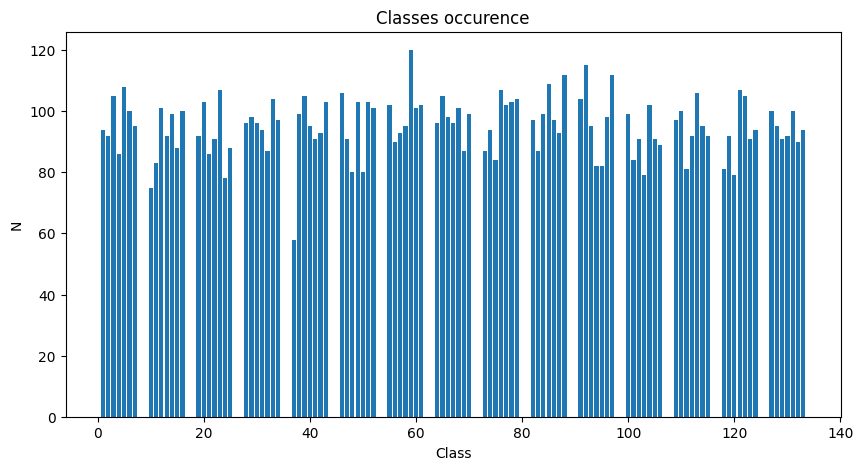

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Classes occurence')
plt.xlabel('Class')
plt.ylabel('N')
plt.show()

Define augmentations
-----

1. Random horizontal flip
2. Random vertical flip
3. Random 90° rotation (must correctly rotate orientation labels: up → right → down → left)
4. Random brightness/contrast
5. Gaussian noise
6. Random erasing

In [13]:
class Augmentation:
  """
  Augmentation types. An image can be modified according to one of those augmentations.
  """
  total = 6

  HORIZONTAL_FLIP = 0
  VERTICAL_FLIP = 1
  ROTATION = 2
  GAUSSIAN_NOISE = 3
  JITTER = 4
  ERASING = 5

class Column:
  """
  Label column indices for readability.
  """
  SQUARES = 0
  CIRCLES = 1
  UP = 2
  RIGHT = 3
  DOWN = 4
  LEFT = 5

class AugmentationTransform:
  def __init__(self, data, image_size, augmentation_probabilities: dict[Augmentation, float]):
      self.data = data


      self.augmentations = torch.zeros(size=(Augmentation.total,))
      for augmentation in range(Augmentation.total):
        print(f"Augmentation {augmentation} probability: {augmentation_probabilities.get(augmentation, 0.0)}")
        self.augmentations[augmentation] = augmentation_probabilities.get(augmentation, 0.0)
      self.image_size = image_size
      self.jitter = torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2)
      self.eraser = torchvision.transforms.RandomErasing(scale=(0.03, 0.06))
      self.gaussian_noise_level = 0.1

  def __call__(self, image, label):
      return self.augment_item(image.clone(), label.clone())

  def augment_item(self, image, label) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Randomly apply augmentations with a given probability each.
    """
    probs = torch.rand(6)
    if probs[0] < self.augmentations[Augmentation.HORIZONTAL_FLIP]:
      image, label = self.augmentation_flip(image, label, Augmentation.HORIZONTAL_FLIP)

    if probs[1] < self.augmentations[Augmentation.VERTICAL_FLIP]:
      image, label = self.augmentation_flip(image, label, Augmentation.VERTICAL_FLIP)

    if probs[2] < self.augmentations[Augmentation.ROTATION]:
      image, label = self.augmentation_rotation(image, label)

    if probs[3] < self.augmentations[Augmentation.GAUSSIAN_NOISE]:
      image, label = self.augmentation_gaussian(image, label, noise_level=self.gaussian_noise_level)

    if probs[4] < self.augmentations[Augmentation.JITTER]:
      image, label = self.augmentation_jitter(image, label)

    if probs[5] < self.augmentations[Augmentation.ERASING]:
      image, label = self.augmentation_erasing(image, label)
    return image, label

  def augmentation_flip(self, image: torch.Tensor, label: torch.Tensor, flip_direction: Augmentation) -> tuple:
    """
    Flip a subset of dataset images in-place.
    :param image: image data
    :param label: label data
    :param flip_direction: either horizontally or vertically
    :return: None
    """
    assert flip_direction == Augmentation.HORIZONTAL_FLIP or Augmentation.VERTICAL_FLIP, "Invalid flip direction"

    #alias for readability
    horizontal = (flip_direction == Augmentation.HORIZONTAL_FLIP)

    # flip
    image_shaped = image.reshape((self.image_size.x, self.image_size.y))
    if horizontal:
      image_flipped = torch.flip(image_shaped, dims=(1,)) # only the horizontal
    else: # vertical
      image_flipped = torch.flip(image_shaped, dims=(0,))
    image = image_flipped.reshape((self.image_size.x * self.image_size.y,))

    new_label = label.clone()
    # relabel
    if horizontal:
      new_label[Column.LEFT], new_label[Column.RIGHT] = label[Column.RIGHT], label[Column.LEFT]
    else: # vertical
      new_label[Column.UP], new_label[Column.DOWN] = label[Column.DOWN], label[Column.UP]
    return image, new_label

  def augmentation_rotation(self, image: torch.Tensor, label: torch.Tensor) -> tuple:
    """
    Rotate image either clockwise or counterclockwise with 50/50 probability.
    :param image: image data
    :param label: label data
    :return: tuple (image, label)
    """
    image_shaped = image.reshape((self.image_size.x, self.image_size.y))

    new_label = label.clone()
    clockwise = torch.randint(0, 2, size=(1,))[0] < 0.5
    if clockwise:
      image_rotated = torch.rot90(image_shaped, k=1, dims=(0, 1))
      new_label[Column.UP], new_label[Column.RIGHT], new_label[Column.DOWN], new_label[Column.LEFT] = \
        label[Column.LEFT], label[Column.UP], label[Column.RIGHT], label[Column.DOWN]
    else:
      image_rotated = torch.rot90(image_shaped, k=-1, dims=(0, 1))
      new_label[Column.UP], new_label[Column.LEFT], new_label[Column.DOWN], new_label[Column.RIGHT] = \
        label[Column.RIGHT], label[Column.UP], label[Column.LEFT], label[Column.DOWN]

    image = image_rotated.reshape((self.image_size.x * self.image_size.y,))
    return image, new_label

  def augmentation_gaussian(self, image: torch.Tensor, label: torch.Tensor, noise_level: float) -> tuple:
    """
    Add Gaussian noise to image.
    :param image: image data
    :param label: label data (unchanged)
    :param noise_level: pixel value variance
    :return: tuple (image, label)
    """
    noise = torch.normal(0., 1., size=image.shape)
    image = image + noise_level * noise
    image = torch.clamp(image, 0, 1)
    return image, label

  def augmentation_jitter(self, image: torch.Tensor, label: torch.Tensor) -> tuple:
    """
    Add random brightness/contrast changes to the image.
    :param image: image data
    :param label: label data (unchanged)
    :return: tuple (image, label)
    """
    image_shaped = image.reshape((1, self.image_size.x, self.image_size.y))
    image_jittered = self.jitter(image_shaped)
    image = image_jittered.reshape((self.image_size.x * self.image_size.y,))
    return image, label

  def augmentation_erasing(self, image: torch.Tensor, label: torch.Tensor) -> tuple:
    """
    Erase a random part of the image.
    :param image: image data
    :param label: label data (unchanged)
    :return: tuple (image, label)
    """
    image_shaped = image.reshape((1, self.image_size.x, self.image_size.y))
    imaged_erased = self.eraser(image_shaped)
    image = imaged_erased.reshape((self.image_size.x * self.image_size.y,))
    return image, label

Verify the dataset and augmentations visually
----

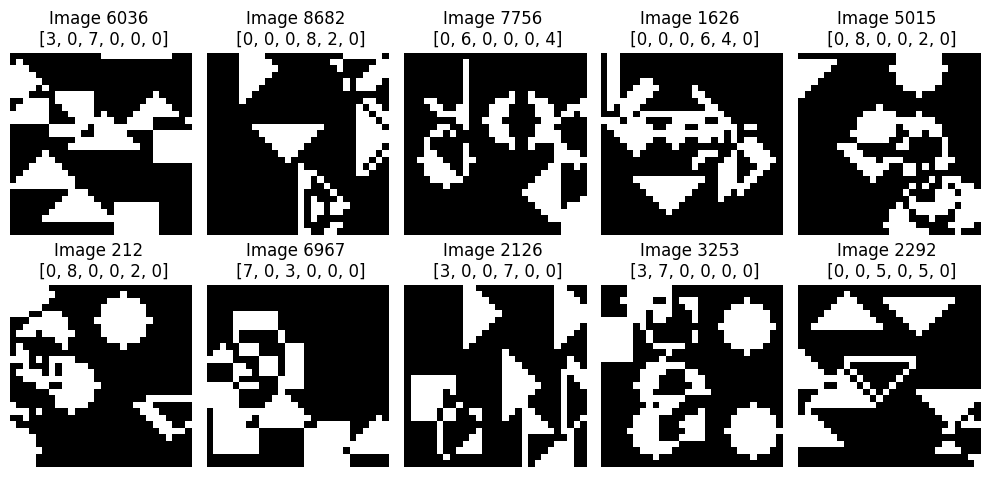

In [14]:
import matplotlib.pyplot as plt
import random

random_indices = random.sample(range(dataset.n_images), 10)

plt.figure(figsize=(10, 5))
for i, index in enumerate(random_indices):
    image_data = dataset.image_data[index].reshape((dataset.image_size.y, dataset.image_size.x))
    label = list([int(k) for k in dataset.y[index]])
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_data.numpy(), cmap='gray')
    plt.title(f"Image {index} \n {label}")
    plt.axis('off')

plt.tight_layout()
plt.savefig("dataset_example_nonaugmented.jpg")
plt.show()

Augmentation 0 probability: 0.5
Augmentation 1 probability: 0.5
Augmentation 2 probability: 0.5
Augmentation 3 probability: 0.2
Augmentation 4 probability: 0.5
Augmentation 5 probability: 0.5


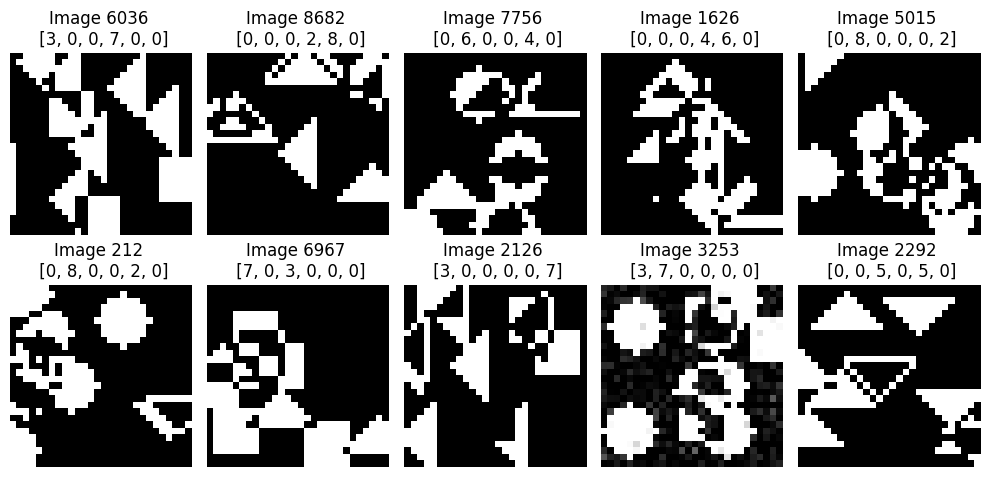

In [15]:
transform = AugmentationTransform(dataset,
                                  dataset.image_size,
                             {Augmentation.HORIZONTAL_FLIP: 0.5,
                              Augmentation.VERTICAL_FLIP: 0.5,
                              Augmentation.ROTATION: 0.5,
                              Augmentation.GAUSSIAN_NOISE: 0.2,
                              Augmentation.JITTER: 0.5,
                              Augmentation.ERASING: 0.5})

plt.figure(figsize=(10, 5))
for i, index in enumerate(random_indices):
    sample_image, sample_label = dataset.image_data[index], dataset.y[index]
    sample_image_augmented, sample_label_augmented = transform(sample_image, sample_label)
    image_data = sample_image_augmented.reshape((dataset.image_size.y, dataset.image_size.x))
    label = list([int(k) for k in sample_label_augmented])
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_data.numpy(), cmap='gray')
    plt.title(f"Image {index} \n {label}")
    plt.axis('off')

plt.tight_layout()
plt.savefig("dataset_example_augmented.jpg")
plt.show()

In [16]:
sample_indices = [0, 100, 500, 1000, 5000]
for idx in sample_indices:
    label = dataset.y[idx]
    nonzero_count = (label > 0).sum().item()
    total = label.sum().item()
    print(f"Index {idx}: {label.tolist()}, nonzero={nonzero_count}, sum={total}")

Index 0: [0.0, 0.0, 4.0, 0.0, 6.0, 0.0], nonzero=2, sum=10.0
Index 100: [6.0, 0.0, 0.0, 0.0, 4.0, 0.0], nonzero=2, sum=10.0
Index 500: [0.0, 7.0, 3.0, 0.0, 0.0, 0.0], nonzero=2, sum=10.0
Index 1000: [0.0, 0.0, 0.0, 8.0, 2.0, 0.0], nonzero=2, sum=10.0
Index 5000: [5.0, 0.0, 0.0, 0.0, 5.0, 0.0], nonzero=2, sum=10.0


Set up the model
===

1. **Classifies** each image into one of **135 possible configurations**, representing:

   * which **two shape classes** appear, and
   * how their counts (1–9) sum to 10.

   → Example: "3 circles + 7 squares" is one configuration class.

2. **Regresses** the number of shapes of each type (a 6-dimensional real-valued output).

3. Combines both objectives in a **joint loss** function (Hint: losses are implemented in PyTorch):


$$ Loss = \text{NLLLoss(classification)} + \lambda_{\text{cnt}} \cdot \text{SmoothL1Loss(regression)} $$

### Architecture constraints
```python
nn.Sequential(
    nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(64 * 28 * 28, 256), nn.ReLU()
)
```

**two separate heads**:

* `head_cls`: outputs log-probabilities for 135 classes
* `head_cnt`: outputs 6 regression values (counts)

The model must return two outputs: `(log_probs, counts)`.

In [64]:
class ShapeClassifier(nn.Module):
    @staticmethod
    def create_feature_extractor():
        feature_extractor = torch.nn.Sequential(
        nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.Linear(64 * 28 * 28, 256), nn.ReLU())

        return feature_extractor

    def __init__(self, optimizer=torch.optim.Adam, lr=1e-3, epochs=100, batch_size=64, batch_size_val=1000, loss_coef=1):
        super().__init__()
        self.optimizer = optimizer
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.batch_size_val = batch_size_val

        self.loss_normalization_coef = loss_coef

        self.feature_extractor = self.create_feature_extractor()
        self.head_shapes = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 135))
        self.head_counts = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 6))

    def loss(self, logits_cls, target_shape, logits_counts, target_counts):
        return (torch.nn.functional.nll_loss(torch.log_softmax(logits_cls, dim=1), target_shape, reduction='mean') +
                self.loss_normalization_coef * torch.nn.functional.smooth_l1_loss(logits_counts, target_counts))

    def reg_loss(self, logits_counts, target_counts):
        return torch.nn.functional.smooth_l1_loss(logits_counts, target_counts)

    def forward(self, x):
        features = self.feature_extractor(x)
        logits_cls = self.head_shapes(features)
        logits_counts = self.head_counts(features)
        return logits_cls, logits_counts


In [21]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

Define the training loop
----

In [57]:
from collections import Counter
IMAGE_SIZE = dataset.image_size

def training_loop(model, optimizer, early_stopping, train_loader, test_loader, epochs, reg_loss_only=False):
    """
    Model training loop.
    :param model: model to train.
    :param optimizer: optimizer to use.
    :param early_stopping: early stopping callback. Can be None.
    :param train_loader: training data loader.
    :param test_loader: test data loader.
    :param epochs: number of epochs to train for. The actual number may be less is early stopping is defnined.
    :param reg_loss_only: whether to only use the regression loss or both classification and regression.
    """

    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in tqdm.tqdm(train_loader):
            images = images.view(-1, 1, IMAGE_SIZE.x, IMAGE_SIZE.y).to(device)
            labels = labels.to(device)

            cls_goal = shapes_to_output_class(labels)
            cnt_goal = labels

            cls_y, cnt_y = model(images)

            if reg_loss_only:
              loss = model.reg_loss(cnt_y, cnt_goal)
            else:
              loss = model.loss(cls_y, cls_goal, cnt_y, cnt_goal)

            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_predictions = cls_y.argmax(dim=1)
            train_correct += (train_predictions == cls_goal).sum().item()
            train_total += labels.size(0)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(-1, 1, 28, 28).to(device)
                labels = labels.to(device)

                target_counts = labels
                target_shape = shapes_to_output_class(labels)

                logits_cls, logits_counts = model(images)
                if reg_loss_only:
                  loss = model.reg_loss(logits_counts, target_counts)
                else:
                  loss = model.loss(logits_cls, target_shape, logits_counts, target_counts)

                test_loss += loss.item()

                # Accuracy
                predictions = logits_cls.argmax(dim=1)
                correct += (predictions == target_shape).sum().item()
                total += labels.size(0)

        cls_loss = torch.nn.functional.cross_entropy(logits_cls, target_shape)
        reg_loss = torch.nn.functional.smooth_l1_loss(logits_counts, target_counts)
        sum_loss = cls_loss + model.loss_normalization_coef * reg_loss

        train_losses.append(total_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        print(f"Cls: {cls_loss:.4f} | Reg: {reg_loss:.4f} | Total: {sum_loss:.4f}")
        print(f"Epoch {epoch+1}/{model.epochs} | "
              f"Train Loss: {total_loss/len(train_loader):.4f} | "
              f"Test Loss: {test_loss/len(test_loader):.4f}")
        if not reg_loss_only:
          # It doesn't make much sense to check accuracy of an output consisting of real numbers.
          print(f"Train Acc: {100*train_correct/train_total:.2f}% | "
                f"Test Acc: {100*correct/total:.2f}%")

        if early_stopping is not None:
          early_stopping(sum_loss, model)
          if early_stopping.early_stop:
              print("Early stopping")
              break

    if early_stopping is not None:
      early_stopping.load_best_model(model)
    return train_losses, test_losses

Load data
====

In [23]:
n_images = dataset.n_images
split_point = int(TRAIN_SIZE)

train_transform = AugmentationTransform(dataset,
                                  dataset.image_size,
                             {Augmentation.HORIZONTAL_FLIP: 0.3,
                              Augmentation.VERTICAL_FLIP: 0.3,
                              Augmentation.ROTATION: 0.25,
                              Augmentation.GAUSSIAN_NOISE: 0.1,
                              Augmentation.JITTER: 0.2,
                              Augmentation.ERASING: 0.2})
train_dataset = Dataset("data/", transform=train_transform, verbose=True)
# train_dataset = Dataset("data/", transform=None, verbose=True)
train_dataset.load()
train_subset = torch.utils.data.Subset(train_dataset, list(range(TRAIN_SIZE)))

test_dataset = Dataset("data/", transform=None, verbose=False)
test_dataset.image_data = train_dataset.image_data  # Share memory
test_dataset.y = train_dataset.y
test_dataset.n_images = train_dataset.n_images
test_dataset.image_size = train_dataset.image_size
test_subset = torch.utils.data.Subset(test_dataset, list(range(TRAIN_SIZE, n_images)))

Augmentation 0 probability: 0.3
Augmentation 1 probability: 0.3
Augmentation 2 probability: 0.25
Augmentation 3 probability: 0.1
Augmentation 4 probability: 0.2
Augmentation 5 probability: 0.2
Initialized in verbose mode
Reading all data
Reading labels
Labels:
            name  squares  circles  up  right  down  left
0  img_00000.png        0        0   4      0     6     0
1  img_00001.png        0        0   0      5     0     5
2  img_00002.png        0        0   8      0     2     0
3  img_00003.png        0        7   0      0     0     3
4  img_00004.png        0        0   3      0     0     7
Image shape is set to (28, 28) based on img_00000.png


100%|██████████| 10000/10000 [00:02<00:00, 3681.21it/s]

Data shape is torch.Size([10000, 784]) (10000 images of (28,28) size)


In [24]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=BATCH_SIZE_VALIDATION, shuffle=False)

In [25]:
print(f"Train loader size: {len(train_loader.dataset)}")
print(f"Test loader size: {len(test_loader.dataset)}")

Train loader size: 9000
Test loader size: 1000


In [26]:
# Verification
for i in range(5):
    label = dataset.y[i]
    class_idx = shapes_to_output_class(label)
    print(f"Label: {label.tolist()} → Class: {class_idx.item()}")
    print(f"Should be: {output_classes[class_idx]}")

Label: [0.0, 0.0, 4.0, 0.0, 6.0, 0.0] → Class: 93
Should be: tensor([2, 4, 4])
Label: [0.0, 0.0, 0.0, 5.0, 0.0, 5.0] → Class: 121
Should be: tensor([3, 5, 5])
Label: [0.0, 0.0, 8.0, 0.0, 2.0, 0.0] → Class: 97
Should be: tensor([2, 4, 8])
Label: [0.0, 7.0, 0.0, 0.0, 0.0, 3.0] → Class: 78
Should be: tensor([1, 5, 7])
Label: [0.0, 0.0, 3.0, 0.0, 0.0, 7.0] → Class: 101
Should be: tensor([2, 5, 3])


Train the model
===

Experiment 1: Classification-only
----

In [65]:
model_class = ShapeClassifier(loss_coef=0).to(device)
optimizer = torch.optim.Adam(model_class.parameters(), lr=1e-3)
early_stopping = EarlyStopping(patience=10, delta=0.01)

In [66]:
train_losses, test_losses = training_loop(model_class, optimizer, early_stopping, train_loader, test_loader, EPOCHS, reg_loss_only=False)

100%|██████████| 141/141 [00:03<00:00, 41.62it/s]


Cls: 4.6771 | Reg: 1.5170 | Total: 4.6771
Epoch 1/100 | Train Loss: 4.7567 | Test Loss: 4.6771
Train Acc: 1.07% | Test Acc: 1.40%


100%|██████████| 141/141 [00:03<00:00, 40.53it/s]


Cls: 4.5855 | Reg: 1.5107 | Total: 4.5855
Epoch 2/100 | Train Loss: 4.6804 | Test Loss: 4.5855
Train Acc: 0.99% | Test Acc: 1.40%


100%|██████████| 141/141 [00:03<00:00, 39.76it/s]


Cls: 3.8784 | Reg: 1.5012 | Total: 3.8784
Epoch 3/100 | Train Loss: 4.2731 | Test Loss: 3.8784
Train Acc: 2.34% | Test Acc: 4.50%


100%|██████████| 141/141 [00:03<00:00, 42.91it/s]


Cls: 3.6268 | Reg: 1.5226 | Total: 3.6268
Epoch 4/100 | Train Loss: 3.9214 | Test Loss: 3.6268
Train Acc: 3.81% | Test Acc: 5.60%


100%|██████████| 141/141 [00:03<00:00, 42.46it/s]


Cls: 3.0962 | Reg: 1.6080 | Total: 3.0962
Epoch 5/100 | Train Loss: 3.5976 | Test Loss: 3.0962
Train Acc: 5.87% | Test Acc: 11.70%


100%|██████████| 141/141 [00:03<00:00, 37.12it/s]


Cls: 2.7699 | Reg: 1.6419 | Total: 2.7699
Epoch 6/100 | Train Loss: 3.1957 | Test Loss: 2.7699
Train Acc: 9.63% | Test Acc: 13.90%


100%|██████████| 141/141 [00:03<00:00, 43.08it/s]


Cls: 2.4454 | Reg: 1.7089 | Total: 2.4454
Epoch 7/100 | Train Loss: 2.9536 | Test Loss: 2.4454
Train Acc: 11.37% | Test Acc: 21.50%


100%|██████████| 141/141 [00:03<00:00, 42.66it/s]


Cls: 2.3283 | Reg: 1.7225 | Total: 2.3283
Epoch 8/100 | Train Loss: 2.7864 | Test Loss: 2.3283
Train Acc: 13.58% | Test Acc: 20.90%


100%|██████████| 141/141 [00:03<00:00, 42.06it/s]


Cls: 2.2549 | Reg: 1.7286 | Total: 2.2549
Epoch 9/100 | Train Loss: 2.6814 | Test Loss: 2.2549
Train Acc: 14.88% | Test Acc: 25.50%


100%|██████████| 141/141 [00:03<00:00, 38.87it/s]


Cls: 2.1973 | Reg: 1.7474 | Total: 2.1973
Epoch 10/100 | Train Loss: 2.6152 | Test Loss: 2.1973
Train Acc: 16.48% | Test Acc: 24.70%


100%|██████████| 141/141 [00:03<00:00, 43.24it/s]


Cls: 2.1687 | Reg: 1.7633 | Total: 2.1687
Epoch 11/100 | Train Loss: 2.5660 | Test Loss: 2.1687
Train Acc: 17.28% | Test Acc: 26.00%


100%|██████████| 141/141 [00:03<00:00, 38.27it/s]


Cls: 2.0765 | Reg: 1.7777 | Total: 2.0765
Epoch 12/100 | Train Loss: 2.5354 | Test Loss: 2.0765
Train Acc: 17.52% | Test Acc: 30.00%


100%|██████████| 141/141 [00:03<00:00, 37.62it/s]


Cls: 2.0236 | Reg: 1.8005 | Total: 2.0236
Epoch 13/100 | Train Loss: 2.4680 | Test Loss: 2.0236
Train Acc: 18.17% | Test Acc: 31.30%


100%|██████████| 141/141 [00:03<00:00, 38.96it/s]


Cls: 1.9668 | Reg: 1.7841 | Total: 1.9668
Epoch 14/100 | Train Loss: 2.4400 | Test Loss: 1.9668
Train Acc: 19.31% | Test Acc: 32.00%


100%|██████████| 141/141 [00:03<00:00, 43.49it/s]


Cls: 2.0002 | Reg: 1.7768 | Total: 2.0002
Epoch 15/100 | Train Loss: 2.4152 | Test Loss: 2.0002
Train Acc: 20.64% | Test Acc: 33.40%


100%|██████████| 141/141 [00:03<00:00, 39.87it/s]


Cls: 1.9341 | Reg: 1.8042 | Total: 1.9341
Epoch 16/100 | Train Loss: 2.3790 | Test Loss: 1.9341
Train Acc: 21.34% | Test Acc: 31.70%


100%|██████████| 141/141 [00:03<00:00, 40.27it/s]


Cls: 1.9254 | Reg: 1.7623 | Total: 1.9254
Epoch 17/100 | Train Loss: 2.3446 | Test Loss: 1.9254
Train Acc: 21.13% | Test Acc: 34.60%


100%|██████████| 141/141 [00:03<00:00, 43.25it/s]


Cls: 1.9245 | Reg: 1.7762 | Total: 1.9245
Epoch 18/100 | Train Loss: 2.3291 | Test Loss: 1.9245
Train Acc: 21.66% | Test Acc: 33.80%


100%|██████████| 141/141 [00:03<00:00, 42.79it/s]


Cls: 1.8275 | Reg: 1.8086 | Total: 1.8275
Epoch 19/100 | Train Loss: 2.2828 | Test Loss: 1.8275
Train Acc: 23.54% | Test Acc: 37.40%


100%|██████████| 141/141 [00:03<00:00, 37.30it/s]


Cls: 1.8329 | Reg: 1.8098 | Total: 1.8329
Epoch 20/100 | Train Loss: 2.2650 | Test Loss: 1.8329
Train Acc: 23.42% | Test Acc: 34.40%


100%|██████████| 141/141 [00:03<00:00, 43.74it/s]


Cls: 1.7835 | Reg: 1.7937 | Total: 1.7835
Epoch 21/100 | Train Loss: 2.2461 | Test Loss: 1.7835
Train Acc: 24.13% | Test Acc: 38.70%


100%|██████████| 141/141 [00:03<00:00, 43.36it/s]


Cls: 1.7849 | Reg: 1.8228 | Total: 1.7849
Epoch 22/100 | Train Loss: 2.2175 | Test Loss: 1.7849
Train Acc: 24.76% | Test Acc: 36.20%


100%|██████████| 141/141 [00:03<00:00, 41.54it/s]


Cls: 1.7283 | Reg: 1.7999 | Total: 1.7283
Epoch 23/100 | Train Loss: 2.2097 | Test Loss: 1.7283
Train Acc: 24.68% | Test Acc: 38.60%


100%|██████████| 141/141 [00:03<00:00, 40.10it/s]


Cls: 1.7564 | Reg: 1.7883 | Total: 1.7564
Epoch 24/100 | Train Loss: 2.1546 | Test Loss: 1.7564
Train Acc: 26.34% | Test Acc: 40.20%


100%|██████████| 141/141 [00:03<00:00, 44.12it/s]


Cls: 1.7421 | Reg: 1.8143 | Total: 1.7421
Epoch 25/100 | Train Loss: 2.1528 | Test Loss: 1.7421
Train Acc: 25.73% | Test Acc: 39.70%


100%|██████████| 141/141 [00:03<00:00, 43.04it/s]


Cls: 1.7364 | Reg: 1.8311 | Total: 1.7364
Epoch 26/100 | Train Loss: 2.1082 | Test Loss: 1.7364
Train Acc: 26.81% | Test Acc: 39.20%


100%|██████████| 141/141 [00:03<00:00, 37.20it/s]


Cls: 1.6754 | Reg: 1.8201 | Total: 1.6754
Epoch 27/100 | Train Loss: 2.1218 | Test Loss: 1.6754
Train Acc: 26.79% | Test Acc: 41.20%


100%|██████████| 141/141 [00:03<00:00, 42.83it/s]


Cls: 1.7045 | Reg: 1.7800 | Total: 1.7045
Epoch 28/100 | Train Loss: 2.1114 | Test Loss: 1.7045
Train Acc: 26.97% | Test Acc: 42.50%


100%|██████████| 141/141 [00:03<00:00, 42.50it/s]


Cls: 1.7247 | Reg: 1.7966 | Total: 1.7247
Epoch 29/100 | Train Loss: 2.0867 | Test Loss: 1.7247
Train Acc: 27.48% | Test Acc: 38.60%


100%|██████████| 141/141 [00:03<00:00, 41.54it/s]


Cls: 1.7142 | Reg: 1.8187 | Total: 1.7142
Epoch 30/100 | Train Loss: 2.0524 | Test Loss: 1.7142
Train Acc: 28.48% | Test Acc: 38.50%


100%|██████████| 141/141 [00:03<00:00, 39.38it/s]


Cls: 1.6593 | Reg: 1.8033 | Total: 1.6593
Epoch 31/100 | Train Loss: 2.0368 | Test Loss: 1.6593
Train Acc: 29.17% | Test Acc: 40.70%


100%|██████████| 141/141 [00:03<00:00, 43.59it/s]


Cls: 1.6558 | Reg: 1.7842 | Total: 1.6558
Epoch 32/100 | Train Loss: 2.0279 | Test Loss: 1.6558
Train Acc: 30.58% | Test Acc: 41.50%


100%|██████████| 141/141 [00:03<00:00, 42.63it/s]


Cls: 1.6584 | Reg: 1.8021 | Total: 1.6584
Epoch 33/100 | Train Loss: 2.0117 | Test Loss: 1.6584
Train Acc: 29.80% | Test Acc: 40.40%


100%|██████████| 141/141 [00:03<00:00, 38.12it/s]


Cls: 1.6772 | Reg: 1.7970 | Total: 1.6772
Epoch 34/100 | Train Loss: 1.9962 | Test Loss: 1.6772
Train Acc: 30.63% | Test Acc: 41.10%


100%|██████████| 141/141 [00:03<00:00, 43.83it/s]


Cls: 1.6736 | Reg: 1.7895 | Total: 1.6736
Epoch 35/100 | Train Loss: 1.9787 | Test Loss: 1.6736
Train Acc: 31.40% | Test Acc: 38.20%


100%|██████████| 141/141 [00:03<00:00, 42.27it/s]


Cls: 1.6526 | Reg: 1.8054 | Total: 1.6526
Epoch 36/100 | Train Loss: 1.9622 | Test Loss: 1.6526
Train Acc: 31.86% | Test Acc: 40.60%


100%|██████████| 141/141 [00:03<00:00, 42.40it/s]


Cls: 1.5995 | Reg: 1.8113 | Total: 1.5995
Epoch 37/100 | Train Loss: 1.9592 | Test Loss: 1.5995
Train Acc: 31.58% | Test Acc: 43.30%


100%|██████████| 141/141 [00:03<00:00, 38.20it/s]


Cls: 1.6736 | Reg: 1.7922 | Total: 1.6736
Epoch 38/100 | Train Loss: 1.9561 | Test Loss: 1.6736
Train Acc: 31.54% | Test Acc: 37.10%


100%|██████████| 141/141 [00:03<00:00, 43.35it/s]


Cls: 1.6116 | Reg: 1.7791 | Total: 1.6116
Epoch 39/100 | Train Loss: 1.9317 | Test Loss: 1.6116
Train Acc: 32.01% | Test Acc: 42.60%


100%|██████████| 141/141 [00:03<00:00, 42.72it/s]


Cls: 1.5672 | Reg: 1.8214 | Total: 1.5672
Epoch 40/100 | Train Loss: 1.9244 | Test Loss: 1.5672
Train Acc: 32.66% | Test Acc: 42.70%


100%|██████████| 141/141 [00:03<00:00, 37.67it/s]


Cls: 1.6351 | Reg: 1.8055 | Total: 1.6351
Epoch 41/100 | Train Loss: 1.9190 | Test Loss: 1.6351
Train Acc: 33.34% | Test Acc: 42.10%


100%|██████████| 141/141 [00:03<00:00, 42.96it/s]


Cls: 1.6039 | Reg: 1.8005 | Total: 1.6039
Epoch 42/100 | Train Loss: 1.8801 | Test Loss: 1.6039
Train Acc: 33.48% | Test Acc: 41.50%


100%|██████████| 141/141 [00:03<00:00, 43.12it/s]


Cls: 1.6270 | Reg: 1.8100 | Total: 1.6270
Epoch 43/100 | Train Loss: 1.8625 | Test Loss: 1.6270
Train Acc: 34.72% | Test Acc: 40.40%


100%|██████████| 141/141 [00:03<00:00, 44.05it/s]


Cls: 1.5808 | Reg: 1.8252 | Total: 1.5808
Epoch 44/100 | Train Loss: 1.8831 | Test Loss: 1.5808
Train Acc: 34.24% | Test Acc: 42.30%


100%|██████████| 141/141 [00:03<00:00, 37.25it/s]


Cls: 1.6276 | Reg: 1.8303 | Total: 1.6276
Epoch 45/100 | Train Loss: 1.8702 | Test Loss: 1.6276
Train Acc: 33.86% | Test Acc: 42.30%


100%|██████████| 141/141 [00:03<00:00, 43.60it/s]


Cls: 1.5845 | Reg: 1.8501 | Total: 1.5845
Epoch 46/100 | Train Loss: 1.8392 | Test Loss: 1.5845
Train Acc: 35.41% | Test Acc: 44.00%


100%|██████████| 141/141 [00:03<00:00, 43.25it/s]


Cls: 1.5627 | Reg: 1.8089 | Total: 1.5627
Epoch 47/100 | Train Loss: 1.8258 | Test Loss: 1.5627
Train Acc: 35.64% | Test Acc: 42.10%


100%|██████████| 141/141 [00:03<00:00, 38.18it/s]


Cls: 1.6052 | Reg: 1.8279 | Total: 1.6052
Epoch 48/100 | Train Loss: 1.8189 | Test Loss: 1.6052
Train Acc: 35.99% | Test Acc: 41.70%


100%|██████████| 141/141 [00:03<00:00, 43.09it/s]


Cls: 1.5942 | Reg: 1.8015 | Total: 1.5942
Epoch 49/100 | Train Loss: 1.8291 | Test Loss: 1.5942
Train Acc: 35.54% | Test Acc: 41.50%


100%|██████████| 141/141 [00:03<00:00, 43.31it/s]

Cls: 1.5666 | Reg: 1.8045 | Total: 1.5666
Epoch 50/100 | Train Loss: 1.8089 | Test Loss: 1.5666
Train Acc: 35.69% | Test Acc: 42.80%
Early stopping


Experiment 2: Regression-only
---

In [68]:
model_reg = ShapeClassifier(loss_coef=1).to(device)
optimizer = torch.optim.Adam(model_reg.parameters(), lr=1e-3)
early_stopping = EarlyStopping(patience=10, delta=0.01)

In [55]:
model_reg(dataset.__getitem__(54)[0].view(-1, 1, IMAGE_SIZE.x, IMAGE_SIZE.y).to(device))[1]

tensor([[ 0.0272, -0.1083,  4.6517,  0.3197,  0.6400,  3.5330]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [69]:
train_losses_reg, test_losses_reg = training_loop(model_reg, optimizer, early_stopping, train_loader, test_loader, EPOCHS, reg_loss_only=True)

100%|██████████| 141/141 [00:03<00:00, 35.91it/s]


Cls: 4.9301 | Reg: 1.3924 | Total: 6.3225
Epoch 1/100 | Train Loss: 1.4173 | Test Loss: 1.3924


100%|██████████| 141/141 [00:03<00:00, 44.50it/s]


Cls: 4.9565 | Reg: 1.1997 | Total: 6.1562
Epoch 2/100 | Train Loss: 1.3051 | Test Loss: 1.1997


100%|██████████| 141/141 [00:03<00:00, 44.08it/s]


Cls: 5.0549 | Reg: 0.7819 | Total: 5.8368
Epoch 3/100 | Train Loss: 1.0952 | Test Loss: 0.7819


100%|██████████| 141/141 [00:03<00:00, 40.88it/s]


Cls: 5.1484 | Reg: 0.5232 | Total: 5.6716
Epoch 4/100 | Train Loss: 0.9277 | Test Loss: 0.5232


100%|██████████| 141/141 [00:03<00:00, 41.56it/s]


Cls: 5.1465 | Reg: 0.4672 | Total: 5.6136
Epoch 5/100 | Train Loss: 0.8120 | Test Loss: 0.4672


100%|██████████| 141/141 [00:03<00:00, 44.38it/s]


Cls: 5.1053 | Reg: 0.4931 | Total: 5.5984
Epoch 6/100 | Train Loss: 0.7792 | Test Loss: 0.4931


100%|██████████| 141/141 [00:03<00:00, 44.33it/s]


Cls: 5.1317 | Reg: 0.4010 | Total: 5.5327
Epoch 7/100 | Train Loss: 0.7687 | Test Loss: 0.4010


100%|██████████| 141/141 [00:03<00:00, 38.16it/s]


Cls: 5.1198 | Reg: 0.4174 | Total: 5.5371
Epoch 8/100 | Train Loss: 0.7513 | Test Loss: 0.4174


100%|██████████| 141/141 [00:03<00:00, 44.65it/s]


Cls: 5.1230 | Reg: 0.3986 | Total: 5.5216
Epoch 9/100 | Train Loss: 0.7399 | Test Loss: 0.3986


100%|██████████| 141/141 [00:03<00:00, 43.99it/s]


Cls: 5.1184 | Reg: 0.3724 | Total: 5.4909
Epoch 10/100 | Train Loss: 0.7132 | Test Loss: 0.3724


100%|██████████| 141/141 [00:03<00:00, 43.21it/s]


Cls: 5.1184 | Reg: 0.3514 | Total: 5.4699
Epoch 11/100 | Train Loss: 0.7127 | Test Loss: 0.3514


100%|██████████| 141/141 [00:03<00:00, 38.85it/s]


Cls: 5.1079 | Reg: 0.3720 | Total: 5.4799
Epoch 12/100 | Train Loss: 0.7173 | Test Loss: 0.3720


100%|██████████| 141/141 [00:03<00:00, 44.25it/s]


Cls: 5.1007 | Reg: 0.3749 | Total: 5.4756
Epoch 13/100 | Train Loss: 0.7200 | Test Loss: 0.3749


100%|██████████| 141/141 [00:03<00:00, 44.26it/s]


Cls: 5.1085 | Reg: 0.3634 | Total: 5.4720
Epoch 14/100 | Train Loss: 0.7121 | Test Loss: 0.3634


100%|██████████| 141/141 [00:03<00:00, 39.05it/s]


Cls: 5.1030 | Reg: 0.3657 | Total: 5.4687
Epoch 15/100 | Train Loss: 0.7094 | Test Loss: 0.3657


100%|██████████| 141/141 [00:03<00:00, 43.88it/s]


Cls: 5.0839 | Reg: 0.3673 | Total: 5.4512
Epoch 16/100 | Train Loss: 0.6975 | Test Loss: 0.3673


100%|██████████| 141/141 [00:03<00:00, 43.88it/s]


Cls: 5.0846 | Reg: 0.3578 | Total: 5.4424
Epoch 17/100 | Train Loss: 0.7028 | Test Loss: 0.3578


100%|██████████| 141/141 [00:03<00:00, 44.28it/s]


Cls: 5.0823 | Reg: 0.3620 | Total: 5.4443
Epoch 18/100 | Train Loss: 0.6868 | Test Loss: 0.3620


100%|██████████| 141/141 [00:03<00:00, 38.27it/s]


Cls: 5.0799 | Reg: 0.3675 | Total: 5.4474
Epoch 19/100 | Train Loss: 0.6960 | Test Loss: 0.3675


100%|██████████| 141/141 [00:03<00:00, 43.55it/s]


Cls: 5.0845 | Reg: 0.3554 | Total: 5.4399
Epoch 20/100 | Train Loss: 0.6884 | Test Loss: 0.3554


100%|██████████| 141/141 [00:03<00:00, 43.94it/s]


Cls: 5.0974 | Reg: 0.3689 | Total: 5.4663
Epoch 21/100 | Train Loss: 0.6848 | Test Loss: 0.3689


100%|██████████| 141/141 [00:03<00:00, 41.47it/s]


Cls: 5.0681 | Reg: 0.3489 | Total: 5.4170
Epoch 22/100 | Train Loss: 0.6802 | Test Loss: 0.3489


100%|██████████| 141/141 [00:03<00:00, 40.33it/s]


Cls: 5.0818 | Reg: 0.3230 | Total: 5.4048
Epoch 23/100 | Train Loss: 0.6688 | Test Loss: 0.3230


100%|██████████| 141/141 [00:03<00:00, 43.67it/s]


Cls: 5.0556 | Reg: 0.3896 | Total: 5.4452
Epoch 24/100 | Train Loss: 0.6662 | Test Loss: 0.3896


100%|██████████| 141/141 [00:03<00:00, 44.12it/s]


Cls: 5.0771 | Reg: 0.3393 | Total: 5.4163
Epoch 25/100 | Train Loss: 0.6664 | Test Loss: 0.3393


100%|██████████| 141/141 [00:03<00:00, 37.56it/s]


Cls: 5.0745 | Reg: 0.3351 | Total: 5.4096
Epoch 26/100 | Train Loss: 0.6554 | Test Loss: 0.3351


100%|██████████| 141/141 [00:03<00:00, 43.58it/s]


Cls: 5.0592 | Reg: 0.3500 | Total: 5.4093
Epoch 27/100 | Train Loss: 0.6616 | Test Loss: 0.3500


100%|██████████| 141/141 [00:03<00:00, 43.97it/s]


Cls: 5.0477 | Reg: 0.3622 | Total: 5.4099
Epoch 28/100 | Train Loss: 0.6502 | Test Loss: 0.3622


100%|██████████| 141/141 [00:03<00:00, 43.50it/s]


Cls: 5.0575 | Reg: 0.3864 | Total: 5.4440
Epoch 29/100 | Train Loss: 0.6448 | Test Loss: 0.3864


100%|██████████| 141/141 [00:03<00:00, 38.23it/s]


Cls: 5.0412 | Reg: 0.3530 | Total: 5.3942
Epoch 30/100 | Train Loss: 0.6416 | Test Loss: 0.3530


100%|██████████| 141/141 [00:04<00:00, 34.79it/s]


Cls: 5.0552 | Reg: 0.3344 | Total: 5.3896
Epoch 31/100 | Train Loss: 0.6425 | Test Loss: 0.3344


100%|██████████| 141/141 [00:03<00:00, 44.22it/s]


Cls: 5.0536 | Reg: 0.3531 | Total: 5.4067
Epoch 32/100 | Train Loss: 0.6412 | Test Loss: 0.3531


100%|██████████| 141/141 [00:03<00:00, 38.02it/s]


Cls: 5.0547 | Reg: 0.3389 | Total: 5.3937
Epoch 33/100 | Train Loss: 0.6399 | Test Loss: 0.3389


100%|██████████| 141/141 [00:03<00:00, 43.91it/s]


Cls: 5.0466 | Reg: 0.3769 | Total: 5.4235
Epoch 34/100 | Train Loss: 0.6395 | Test Loss: 0.3769


100%|██████████| 141/141 [00:03<00:00, 43.54it/s]


Cls: 5.0340 | Reg: 0.4013 | Total: 5.4353
Epoch 35/100 | Train Loss: 0.6296 | Test Loss: 0.4013


100%|██████████| 141/141 [00:03<00:00, 35.86it/s]


Cls: 5.0328 | Reg: 0.3782 | Total: 5.4110
Epoch 36/100 | Train Loss: 0.6303 | Test Loss: 0.3782


100%|██████████| 141/141 [00:06<00:00, 23.14it/s]


Cls: 5.0313 | Reg: 0.3758 | Total: 5.4071
Epoch 37/100 | Train Loss: 0.6303 | Test Loss: 0.3758


100%|██████████| 141/141 [00:04<00:00, 30.93it/s]


Cls: 5.0236 | Reg: 0.4197 | Total: 5.4432
Epoch 38/100 | Train Loss: 0.6223 | Test Loss: 0.4197


100%|██████████| 141/141 [00:03<00:00, 37.89it/s]


Cls: 5.0372 | Reg: 0.3871 | Total: 5.4244
Epoch 39/100 | Train Loss: 0.6151 | Test Loss: 0.3871


100%|██████████| 141/141 [00:03<00:00, 44.28it/s]

Cls: 5.0522 | Reg: 0.3519 | Total: 5.4041
Epoch 40/100 | Train Loss: 0.6138 | Test Loss: 0.3519
Early stopping


Experiment 3: Multitask
----

In [70]:
model = ShapeClassifier(loss_coef=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
early_stopping = EarlyStopping(patience=10, delta=0.01)
model

ShapeClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=50176, out_features=256, bias=True)
    (10): ReLU()
  )
  (head_shapes): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=256, out_features=135, bias=True)
  )
  (head_counts): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [71]:
train_losses_joint, test_losses_joint = training_loop(model, optimizer, early_stopping, train_loader, test_loader, EPOCHS, reg_loss_only=False)

100%|██████████| 141/141 [00:04<00:00, 35.02it/s]


Cls: 4.3967 | Reg: 1.3267 | Total: 12.3568
Epoch 1/100 | Train Loss: 13.1669 | Test Loss: 12.3568
Train Acc: 1.14% | Test Acc: 2.20%


100%|██████████| 141/141 [00:03<00:00, 42.05it/s]


Cls: 3.4590 | Reg: 0.9191 | Total: 8.9739
Epoch 2/100 | Train Loss: 11.1598 | Test Loss: 8.9739
Train Acc: 3.96% | Test Acc: 9.20%


100%|██████████| 141/141 [00:03<00:00, 39.18it/s]


Cls: 3.1605 | Reg: 0.8597 | Total: 8.3185
Epoch 3/100 | Train Loss: 9.8864 | Test Loss: 8.3185
Train Acc: 7.03% | Test Acc: 11.90%


100%|██████████| 141/141 [00:03<00:00, 36.02it/s]


Cls: 2.5985 | Reg: 0.5290 | Total: 5.7723
Epoch 4/100 | Train Loss: 8.8416 | Test Loss: 5.7723
Train Acc: 10.90% | Test Acc: 21.00%


100%|██████████| 141/141 [00:03<00:00, 37.15it/s]


Cls: 2.2858 | Reg: 0.4283 | Total: 4.8556
Epoch 5/100 | Train Loss: 7.6199 | Test Loss: 4.8556
Train Acc: 15.28% | Test Acc: 27.60%


100%|██████████| 141/141 [00:03<00:00, 39.39it/s]


Cls: 2.2356 | Reg: 0.4356 | Total: 4.8490
Epoch 6/100 | Train Loss: 7.3490 | Test Loss: 4.8490
Train Acc: 17.79% | Test Acc: 30.90%


100%|██████████| 141/141 [00:05<00:00, 26.08it/s]


Cls: 2.1156 | Reg: 0.4136 | Total: 4.5972
Epoch 7/100 | Train Loss: 7.1472 | Test Loss: 4.5972
Train Acc: 18.81% | Test Acc: 31.30%


100%|██████████| 141/141 [00:03<00:00, 36.19it/s]


Cls: 2.0913 | Reg: 0.4030 | Total: 4.5095
Epoch 8/100 | Train Loss: 7.0126 | Test Loss: 4.5095
Train Acc: 19.69% | Test Acc: 33.00%


100%|██████████| 141/141 [00:03<00:00, 38.02it/s]


Cls: 2.0089 | Reg: 0.3642 | Total: 4.1941
Epoch 9/100 | Train Loss: 6.8421 | Test Loss: 4.1941
Train Acc: 20.97% | Test Acc: 30.60%


100%|██████████| 141/141 [00:04<00:00, 33.96it/s]


Cls: 1.9519 | Reg: 0.3646 | Total: 4.1397
Epoch 10/100 | Train Loss: 6.7382 | Test Loss: 4.1397
Train Acc: 22.00% | Test Acc: 34.50%


100%|██████████| 141/141 [00:04<00:00, 32.15it/s]


Cls: 1.9382 | Reg: 0.3740 | Total: 4.1819
Epoch 11/100 | Train Loss: 6.6683 | Test Loss: 4.1819
Train Acc: 22.48% | Test Acc: 34.20%


100%|██████████| 141/141 [00:06<00:00, 20.99it/s]


Cls: 1.9086 | Reg: 0.3429 | Total: 3.9660
Epoch 12/100 | Train Loss: 6.6589 | Test Loss: 3.9660
Train Acc: 23.48% | Test Acc: 33.60%


100%|██████████| 141/141 [00:04<00:00, 31.16it/s]


Cls: 1.8263 | Reg: 0.3377 | Total: 3.8524
Epoch 13/100 | Train Loss: 6.5722 | Test Loss: 3.8524
Train Acc: 23.62% | Test Acc: 37.90%


100%|██████████| 141/141 [00:03<00:00, 41.88it/s]


Cls: 1.8300 | Reg: 0.3602 | Total: 3.9909
Epoch 14/100 | Train Loss: 6.4793 | Test Loss: 3.9909
Train Acc: 24.36% | Test Acc: 38.20%


100%|██████████| 141/141 [00:03<00:00, 38.90it/s]


Cls: 1.7922 | Reg: 0.3270 | Total: 3.7541
Epoch 15/100 | Train Loss: 6.4740 | Test Loss: 3.7541
Train Acc: 24.23% | Test Acc: 37.40%


100%|██████████| 141/141 [00:03<00:00, 38.50it/s]


Cls: 1.8409 | Reg: 0.3502 | Total: 3.9419
Epoch 16/100 | Train Loss: 6.3760 | Test Loss: 3.9419
Train Acc: 25.11% | Test Acc: 35.20%


100%|██████████| 141/141 [00:03<00:00, 41.26it/s]


Cls: 1.7670 | Reg: 0.3234 | Total: 3.7077
Epoch 17/100 | Train Loss: 6.3753 | Test Loss: 3.7077
Train Acc: 24.98% | Test Acc: 37.00%


100%|██████████| 141/141 [00:03<00:00, 36.83it/s]


Cls: 1.7781 | Reg: 0.3424 | Total: 3.8326
Epoch 18/100 | Train Loss: 6.3063 | Test Loss: 3.8326
Train Acc: 25.97% | Test Acc: 37.80%


100%|██████████| 141/141 [00:04<00:00, 28.78it/s]


Cls: 1.7466 | Reg: 0.3430 | Total: 3.8048
Epoch 19/100 | Train Loss: 6.3873 | Test Loss: 3.8048
Train Acc: 25.49% | Test Acc: 39.30%


100%|██████████| 141/141 [00:04<00:00, 32.30it/s]


Cls: 1.7392 | Reg: 0.3554 | Total: 3.8713
Epoch 20/100 | Train Loss: 6.3125 | Test Loss: 3.8713
Train Acc: 25.94% | Test Acc: 40.70%


100%|██████████| 141/141 [00:05<00:00, 27.74it/s]


Cls: 1.7460 | Reg: 0.3508 | Total: 3.8510
Epoch 21/100 | Train Loss: 6.2647 | Test Loss: 3.8510
Train Acc: 27.08% | Test Acc: 38.30%


100%|██████████| 141/141 [00:04<00:00, 34.92it/s]


Cls: 1.7372 | Reg: 0.3486 | Total: 3.8286
Epoch 22/100 | Train Loss: 6.2164 | Test Loss: 3.8286
Train Acc: 27.32% | Test Acc: 39.30%


100%|██████████| 141/141 [00:03<00:00, 37.23it/s]


Cls: 1.7512 | Reg: 0.3424 | Total: 3.8056
Epoch 23/100 | Train Loss: 6.1985 | Test Loss: 3.8056
Train Acc: 27.56% | Test Acc: 35.00%


100%|██████████| 141/141 [00:03<00:00, 39.26it/s]


Cls: 1.7086 | Reg: 0.3351 | Total: 3.7194
Epoch 24/100 | Train Loss: 6.1299 | Test Loss: 3.7194
Train Acc: 28.49% | Test Acc: 37.60%


100%|██████████| 141/141 [00:04<00:00, 32.73it/s]


Cls: 1.6649 | Reg: 0.3200 | Total: 3.5852
Epoch 25/100 | Train Loss: 6.1598 | Test Loss: 3.5852
Train Acc: 28.52% | Test Acc: 42.00%


100%|██████████| 141/141 [00:04<00:00, 32.51it/s]


Cls: 1.6898 | Reg: 0.3377 | Total: 3.7159
Epoch 26/100 | Train Loss: 6.2107 | Test Loss: 3.7159
Train Acc: 28.13% | Test Acc: 39.50%


100%|██████████| 141/141 [00:04<00:00, 28.89it/s]


Cls: 1.6886 | Reg: 0.3552 | Total: 3.8195
Epoch 27/100 | Train Loss: 6.1370 | Test Loss: 3.8195
Train Acc: 28.98% | Test Acc: 41.50%


100%|██████████| 141/141 [00:03<00:00, 41.49it/s]


Cls: 1.6445 | Reg: 0.3090 | Total: 3.4987
Epoch 28/100 | Train Loss: 6.1565 | Test Loss: 3.4987
Train Acc: 28.69% | Test Acc: 40.40%


100%|██████████| 141/141 [00:03<00:00, 41.87it/s]


Cls: 1.6460 | Reg: 0.3280 | Total: 3.6140
Epoch 29/100 | Train Loss: 6.0541 | Test Loss: 3.6140
Train Acc: 28.46% | Test Acc: 42.80%


100%|██████████| 141/141 [00:03<00:00, 40.73it/s]


Cls: 1.6205 | Reg: 0.3131 | Total: 3.4994
Epoch 30/100 | Train Loss: 6.0903 | Test Loss: 3.4994
Train Acc: 29.16% | Test Acc: 40.60%


100%|██████████| 141/141 [00:03<00:00, 37.72it/s]


Cls: 1.6221 | Reg: 0.3096 | Total: 3.4796
Epoch 31/100 | Train Loss: 5.9805 | Test Loss: 3.4796
Train Acc: 30.22% | Test Acc: 41.30%


100%|██████████| 141/141 [00:03<00:00, 41.98it/s]


Cls: 1.6744 | Reg: 0.3539 | Total: 3.7977
Epoch 32/100 | Train Loss: 5.9929 | Test Loss: 3.7977
Train Acc: 30.14% | Test Acc: 39.20%


100%|██████████| 141/141 [00:03<00:00, 42.34it/s]


Cls: 1.6129 | Reg: 0.3002 | Total: 3.4140
Epoch 33/100 | Train Loss: 6.0666 | Test Loss: 3.4140
Train Acc: 29.74% | Test Acc: 40.50%


100%|██████████| 141/141 [00:03<00:00, 36.30it/s]


Cls: 1.6448 | Reg: 0.3060 | Total: 3.4811
Epoch 34/100 | Train Loss: 6.0016 | Test Loss: 3.4811
Train Acc: 30.41% | Test Acc: 38.20%


100%|██████████| 141/141 [00:03<00:00, 42.47it/s]


Cls: 1.6041 | Reg: 0.3162 | Total: 3.5015
Epoch 35/100 | Train Loss: 5.9238 | Test Loss: 3.5015
Train Acc: 30.54% | Test Acc: 41.20%


100%|██████████| 141/141 [00:03<00:00, 42.71it/s]


Cls: 1.6211 | Reg: 0.3289 | Total: 3.5946
Epoch 36/100 | Train Loss: 5.9428 | Test Loss: 3.5946
Train Acc: 31.20% | Test Acc: 40.90%


100%|██████████| 141/141 [00:03<00:00, 40.72it/s]


Cls: 1.5852 | Reg: 0.3142 | Total: 3.4703
Epoch 37/100 | Train Loss: 5.9439 | Test Loss: 3.4703
Train Acc: 31.89% | Test Acc: 42.40%


100%|██████████| 141/141 [00:03<00:00, 38.83it/s]


Cls: 1.6161 | Reg: 0.3259 | Total: 3.5717
Epoch 38/100 | Train Loss: 5.9204 | Test Loss: 3.5717
Train Acc: 31.77% | Test Acc: 42.70%


100%|██████████| 141/141 [00:03<00:00, 38.47it/s]


Cls: 1.5990 | Reg: 0.3313 | Total: 3.5866
Epoch 39/100 | Train Loss: 5.9354 | Test Loss: 3.5866
Train Acc: 31.72% | Test Acc: 43.40%


100%|██████████| 141/141 [00:03<00:00, 42.41it/s]


Cls: 1.5603 | Reg: 0.2922 | Total: 3.3134
Epoch 40/100 | Train Loss: 5.9015 | Test Loss: 3.3134
Train Acc: 32.73% | Test Acc: 43.70%


100%|██████████| 141/141 [00:03<00:00, 36.89it/s]


Cls: 1.6014 | Reg: 0.3237 | Total: 3.5436
Epoch 41/100 | Train Loss: 5.8640 | Test Loss: 3.5436
Train Acc: 32.59% | Test Acc: 40.90%


100%|██████████| 141/141 [00:03<00:00, 42.12it/s]


Cls: 1.5569 | Reg: 0.3146 | Total: 3.4446
Epoch 42/100 | Train Loss: 5.8427 | Test Loss: 3.4446
Train Acc: 32.41% | Test Acc: 42.10%


100%|██████████| 141/141 [00:03<00:00, 41.69it/s]


Cls: 1.6068 | Reg: 0.3305 | Total: 3.5896
Epoch 43/100 | Train Loss: 5.7616 | Test Loss: 3.5896
Train Acc: 33.59% | Test Acc: 41.90%


100%|██████████| 141/141 [00:03<00:00, 38.33it/s]


Cls: 1.7023 | Reg: 0.3440 | Total: 3.7662
Epoch 44/100 | Train Loss: 5.7766 | Test Loss: 3.7662
Train Acc: 33.77% | Test Acc: 37.20%


100%|██████████| 141/141 [00:03<00:00, 40.50it/s]


Cls: 1.6110 | Reg: 0.3356 | Total: 3.6248
Epoch 45/100 | Train Loss: 5.7971 | Test Loss: 3.6248
Train Acc: 33.73% | Test Acc: 43.40%


100%|██████████| 141/141 [00:03<00:00, 42.06it/s]


Cls: 1.5400 | Reg: 0.3137 | Total: 3.4220
Epoch 46/100 | Train Loss: 5.7869 | Test Loss: 3.4220
Train Acc: 34.59% | Test Acc: 44.80%


100%|██████████| 141/141 [00:03<00:00, 42.51it/s]


Cls: 1.5534 | Reg: 0.3145 | Total: 3.4406
Epoch 47/100 | Train Loss: 5.7523 | Test Loss: 3.4406
Train Acc: 34.70% | Test Acc: 44.70%


100%|██████████| 141/141 [00:03<00:00, 36.85it/s]


Cls: 1.5524 | Reg: 0.3157 | Total: 3.4465
Epoch 48/100 | Train Loss: 5.7665 | Test Loss: 3.4465
Train Acc: 35.00% | Test Acc: 45.40%


100%|██████████| 141/141 [00:03<00:00, 42.35it/s]


Cls: 1.5683 | Reg: 0.3337 | Total: 3.5708
Epoch 49/100 | Train Loss: 5.7957 | Test Loss: 3.5708
Train Acc: 35.26% | Test Acc: 44.60%


100%|██████████| 141/141 [00:04<00:00, 30.93it/s]


Cls: 1.5593 | Reg: 0.3228 | Total: 3.4964
Epoch 50/100 | Train Loss: 5.8148 | Test Loss: 3.4964
Train Acc: 34.38% | Test Acc: 43.70%
Early stopping


Evaluate the model
===

### (b) **Regression (6-D counts)**

* RMSE per class and overall
* MAE per class and overall

Also plot:

* Training and validation losses
* Validation accuracy and RMSE over epochs


In [77]:
def graph_loss(train_losses, test_losses, graph_name):
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(graph_name)
    plt.show()

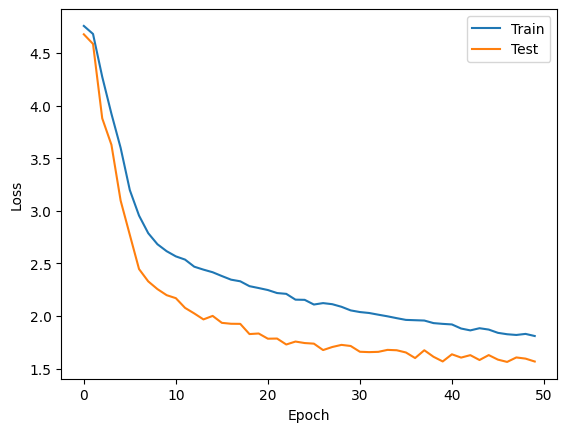

In [78]:
graph_loss(train_losses, test_losses, "loss_classification_only.jpg")

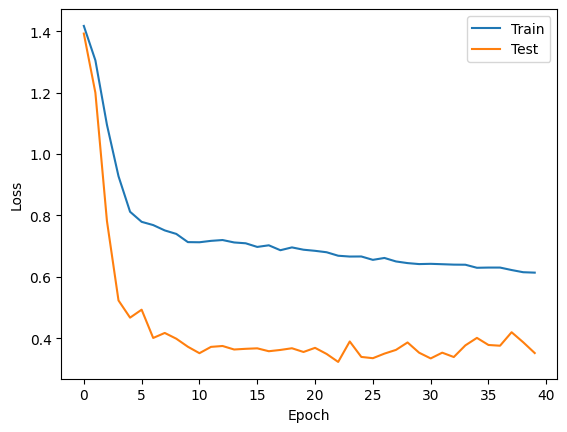

In [79]:
graph_loss(train_losses_reg, test_losses_reg, "loss_regression_only.jpg")

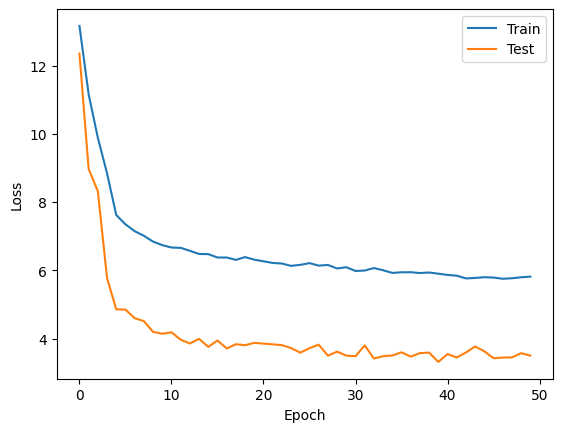

In [80]:
graph_loss(train_losses_joint, test_losses_joint, "loss.jpg")

In [81]:
# Torchmetrics have trouble being imported; using a manual fallback.
def calculate_metrics(predictions, targets, num_classes):
    precision_per_class = []
    recall_per_class = []
    f1_per_class = []

    for c in range(num_classes):
        if not torch.any(targets == c):
          continue
        #print(len(predictions), len(targets))
        #print(predictions == c)
        tp = ((predictions == c) & (targets == c)).sum().float()
        fp = ((predictions == c) & (targets != c)).sum().float()
        fn = ((predictions != c) & (targets == c)).sum().float()

        precision = tp / (tp + fp) if (tp + fp) > 0 else torch.tensor(0.0)
        recall = tp / (tp + fn) if (tp + fn) > 0 else torch.tensor(0.0)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else torch.tensor(0.0)

        precision_per_class.append(precision)
        recall_per_class.append(recall)
        f1_per_class.append(f1)

    return (torch.stack(precision_per_class).mean().item(),
            torch.stack(recall_per_class).mean().item(),
            torch.stack(f1_per_class).mean().item())

def evaluate_classification_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    num_classes = len(class_counts)
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 1, 28, 28).to(device)
            labels = labels.to(device)

            target_counts = labels
            target_shape = shapes_to_output_class(labels)

            logits_cls, logits_counts = model(images)
            loss = model.loss(logits_cls, target_shape, logits_counts, target_counts)

            test_loss += loss.item()

            # Accuracy
            predictions = logits_cls.argmax(dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target_shape.cpu().numpy())
            correct += (predictions == target_shape).sum().item()
            total += labels.size(0)

    cls_loss = torch.nn.functional.cross_entropy(logits_cls, target_shape)
    reg_loss = torch.nn.functional.smooth_l1_loss(logits_counts, target_counts)
    sum_loss = cls_loss + model.loss_normalization_coef * reg_loss

    precision, recall, f1 = calculate_metrics(torch.Tensor(all_predictions), torch.Tensor(all_targets), num_classes)

    print(f"Cls: {cls_loss:.4f} | Reg: {reg_loss:.4f} | Total: {sum_loss:.4f}")
    print(f"Test Loss: {test_loss/len(test_loader):.4f} | "
          f"Test Acc: {100*correct/total:.2f}% | "
          f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

In [82]:
evaluate_classification_model(model_class, test_loader)
evaluate_classification_model(model, test_loader)

Cls: 1.5666 | Reg: 1.8045 | Total: 1.5666
Test Loss: 1.5666 | Test Acc: 42.80% | Precision: 0.4067 | Recall: 0.4144 | F1: 0.3782
Cls: 1.5593 | Reg: 0.3228 | Total: 3.4964
Test Loss: 3.4964 | Test Acc: 43.70% | Precision: 0.4525 | Recall: 0.4602 | F1: 0.4130


Analyze the failure modes
---

In [83]:
def analyze_features():
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 1, 28, 28).to(device)
            features = model.feature_extractor(images)
            all_features.append(features.cpu())
            all_labels.append(labels)

    features = torch.cat(all_features)
    labels = torch.cat(all_labels)

    # Check feature statistics
    print(f"Feature mean: {features.mean():.4f}")
    print(f"Feature std: {features.std():.4f}")
    print(f"Dead neurons (std < 0.01): {(features.std(dim=0) < 0.01).sum()}/256")
    print(f"Feature rank (approx): {torch.linalg.matrix_rank(features[:1000])}/256")

analyze_features()

Feature mean: 0.4562
Feature std: 1.5729
Dead neurons (std < 0.01): 175/256
Feature rank (approx): 82/256


In [84]:
def analyze_predictions():
    model.eval()
    shape_correct = 0
    count_correct = 0
    both_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 1, 28, 28).to(device)
            labels = labels.to(device)

            logits_cls, _ = model(images)
            preds = logits_cls.argmax(dim=1)
            targets = shapes_to_output_class(labels)

            for i in range(len(preds)):
                pred_class = output_classes[preds[i]]
                true_class = output_classes[targets[i]]

                # Check if shape types match (first two elements)
                if pred_class[0] == true_class[0] and pred_class[1] == true_class[1]:
                    shape_correct += 1

                # Check if count matches (third element)
                if pred_class[2] == true_class[2]:
                    count_correct += 1

                if preds[i] == targets[i]:
                    both_correct += 1

                total += 1

    print(f"Shape pair accuracy: {100*shape_correct/total:.2f}%")
    print(f"Count accuracy: {100*count_correct/total:.2f}%")
    print(f"Both correct: {100*both_correct/total:.2f}%")
    print(f"\nIf independent: {100*(shape_correct/total)*(count_correct/total):.2f}%")

analyze_predictions()

Shape pair accuracy: 91.60%
Count accuracy: 46.80%
Both correct: 43.70%

If independent: 42.87%


In [102]:
# Analyze errors by shape pair
from collections import defaultdict

errors_by_shapes = defaultdict(list)
shape_names = ["circle", "square", "t_up", "t_down", "t_left", "t_right"]
shape_pairs_matrix = torch.zeros((len(shape_names), len(shape_names)))
confusion_matrix = torch.zeros((len(output_classes), len(output_classes)))

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 1, 28, 28).to(device)
        labels = labels.to(device)

        logits_cls, _ = model(images)
        preds = logits_cls.argmax(dim=1)
        targets = shapes_to_output_class(labels)

        for i in range(len(preds)):
            if preds[i] != targets[i]:
                # Get which shapes are in this sample
                true_class = output_classes[targets[i]]
                pred_class = output_classes[preds[i]]
                shapes = (int(true_class[0]), int(true_class[1]))
                errors_by_shapes[shapes].append((true_class, pred_class))
                shape_pairs_matrix[true_class[0], true_class[1]] += 1
                confusion_matrix[targets[i], preds[i]] += 1

# Find shape pairs with most errors
for shapes, errors in sorted(errors_by_shapes.items(), key=lambda x: len(x[1]), reverse=True)[:5]:
    print(f"\nShape pair ({shape_names[shapes[0]]}, {shape_names[shapes[1]]}): {len(errors)} errors")
    #print(f"Example errors: {errors[:3]}")


Shape pair (t_down, t_right): 51 errors

Shape pair (t_up, t_left): 45 errors

Shape pair (t_left, t_right): 43 errors

Shape pair (square, t_down): 43 errors

Shape pair (square, t_up): 42 errors


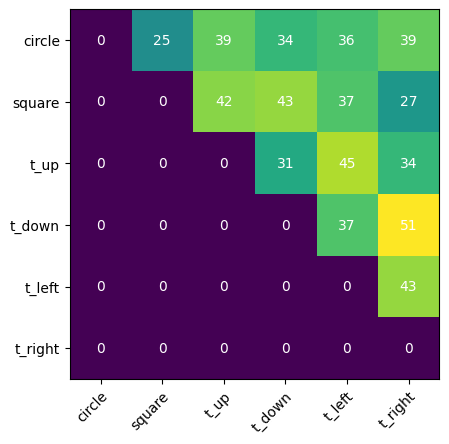

In [103]:
fig, ax = plt.subplots()
im = ax.imshow(shape_pairs_matrix, cmap='hot', interpolation='nearest')

ax.set_xticks(range(len(shape_names)), labels=shape_names,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(shape_names)), labels=shape_names)

for i in range(len(shape_names)):
    for j in range(len(shape_names)):
        text = ax.text(j, i, int(shape_pairs_matrix[i, j]),
                       ha="center", va="center", color="w")


plt.imshow(shape_pairs_matrix)
plt.show()

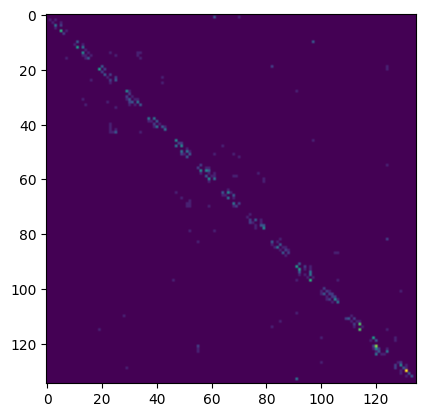

In [107]:
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap='hot', interpolation='nearest')


plt.imshow(confusion_matrix)
plt.show()